# Introduction
<a id="0"></a>

This is a Web Scraping and data analysis project for Airbnb listing. The data was scraped from <a href='https://www.airbnb.com/'>website</a> using BeautifulSoup and requests (detail please refer <a href='https://github.com/BryanChin991/webscrapping/blob/main/Abnb/WScrapping_Abnb.py'>here</a>). The raw data was compiled via web scrapping , and data cleaning was performed to generate meaningful data frame using pandas. The clean dataset will then analyzed using numpy, matplotlib and seaborn. Below is the series of questions asking during data analysis

1. [What Room type has highest price in MYR (Overall and per guest) ?](#1) 
2. [Did wifi, air-cond, kitchen or self-check bring impact to the price ?](#2)
    - [wifi](#3)
    - [air-cond](#4)
    - [kitchen](#5)
    - [Self-check in](#6)
    
3. [Bed type, Number of bed and price relationship](#8)
4. [Did number of bath bring impact to the price ?](#9)
5. [Location and room price?](#10)
5. [Correlation between rating and price](#7)

### [Conclusion](#100)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Compilation

### Import listings files

In [2]:
directory = '/Users/Asus/Desktop/Unity Game/python/Data_Analysis/WebScrapping/Abnb/Scraping_lists'

df = pd.DataFrame()
for file in os.listdir(directory):
    df = df.append((pd.read_csv(os.path.join(directory, file))), ignore_index=True)

### FIrst glance of data

In [3]:
df.to_csv('/Users/Asus/Desktop/Unity Game/python/Data_Analysis/WebScrapping/Abnb/dataset_full.csv', index=False)
df.head()

,Room type,Name,Descriptions,Rating,Price
0,Entire serviced apartment in Kuala Lumpur,LUXURY Studio with NETFLIX & SKY POOL at CEYLONZ,"4 guests, Studio, 1 bed, 1 bath, Wifi, Air con...",4.86,$19 per night
1,Entire serviced apartment in Kuala Lumpur,★Studio★KL★JLN TUN RAZAK★10min KLCC★IJN★TV Box★,"2 guests, Studio, 1 bed, 1 bath, Wifi, Air con...",4.77,$26 per night
2,Entire rental unit in Kuala Lumpur,Staycation for Fully Vaccinated Guest. KLCC area,"2 guests, 1 bedroom, 1 bed, 1 bath, Wifi, Air ...",4.95,$35 per night
3,Entire serviced apartment in Kuala Lumpur,"350M TO KLCC,VORTEX HIGH FLOOR KLCC VIEW@BLACK...","6 guests, 3 bedrooms, 3 beds, 2 baths, Wifi, A...",NaN,$11 per night
4,Hotel room in Kuala Lumpur,Superior Queen Room,"2 guests, 1 bedroom, 1 bed, 1 private bath, Wi...",4.51,$13 per night


Based on data, we can extract and generate new features as shown below:

    Original Columns    New Columns
  1. Room type.............Room(type) & Location
  2. Description...........Number of guests, Bed type, number of bed, number of bath, wifi, Air-cond, Kitchen and Self check-in
  3. Rating................(unchange)
  4. Price.................Price_in_MYR

# Data Cleaning

### - Checking null value, and drop the row if the row contain all null value

In [4]:
# checking null row
df[df.isnull().any(axis=1)]
# drop null price row / drop all null values in row
df.dropna(how='all', inplace=True)

### - Remove duplicate row

In [5]:
# remove duplicate row
duplicate = df[df['Name'].duplicated(keep=False)]
df.drop_duplicates(keep='first', inplace=True)
df = df.reset_index()

### - Checking row number and Null/ empty row again

In [6]:
print(f'Length of row {len(df)}, number of null:\n{df.isnull().sum()}')
print('\nOnly Rating column consists null value')

Length of row 273, number of null:
index            0
Room type        0
Name             0
Descriptions     0
Rating          16
Price            0
dtype: int64

Only Rating column consists null value


### New features -  Location
- to identify listing area
<p><em><strong>Note:</strong></em> Room type column contain type of room and its location</p>

In [107]:
df['Room type'] = df['Room type'].str.replace(' in ', ',')
df['Location'] = df['Room type'].apply(lambda x: str(x).split(',')[-1])
df['Location'] = df['Location'].str.strip()
location = df.Location.value_counts()

<AxesSubplot:>

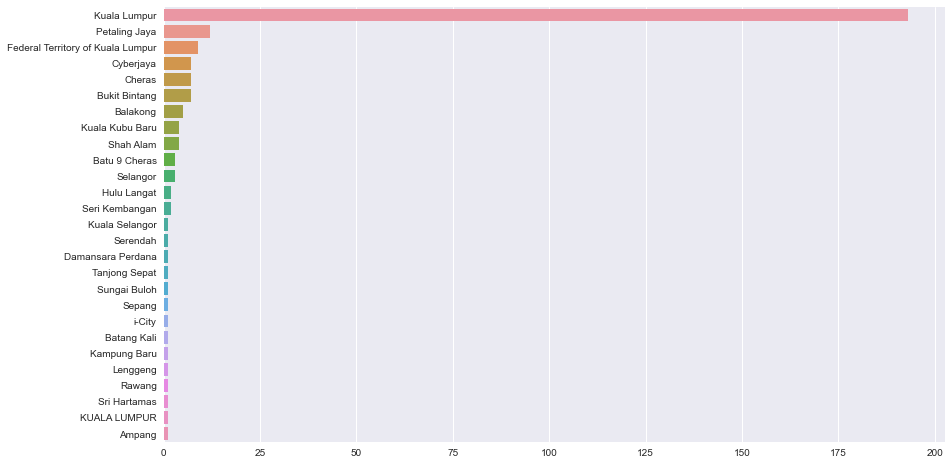

In [108]:
plt.figure(figsize=(14,8))
sns.barplot(y=location.index, x=location.values)

In [8]:
'''
We identify Melaka as one of the location in our list, the row will be removed
'''
df[df.Location=='Melaka']

,index,Room type,Name,Descriptions,Rating,Price,Location
215,370,"Entire condominium (condo),Melaka",✦ATTIC✦Modern Couple's Studio @ MLK Town [NETF...,"2 guests, Studio, 1 bed, 1.5 baths, Wifi, Air ...",NaN,$33 per night,Melaka


In [9]:
# remove special location -- Melaka
df = df[(df.Location != 'Melaka')].reset_index()
print('Unneeded location deleted')
df[df.Location=='Melaka']

Unneeded location deleted


,level_0,index,Room type,Name,Descriptions,Rating,Price,Location


### New features -  Room
- to extract location information from Room type column

In [90]:
df['Room'] = df['Room type'].apply(lambda x : x.split(',')[0])
# df.Room.value_counts()

Text(0.5, 0, 'Quantity')

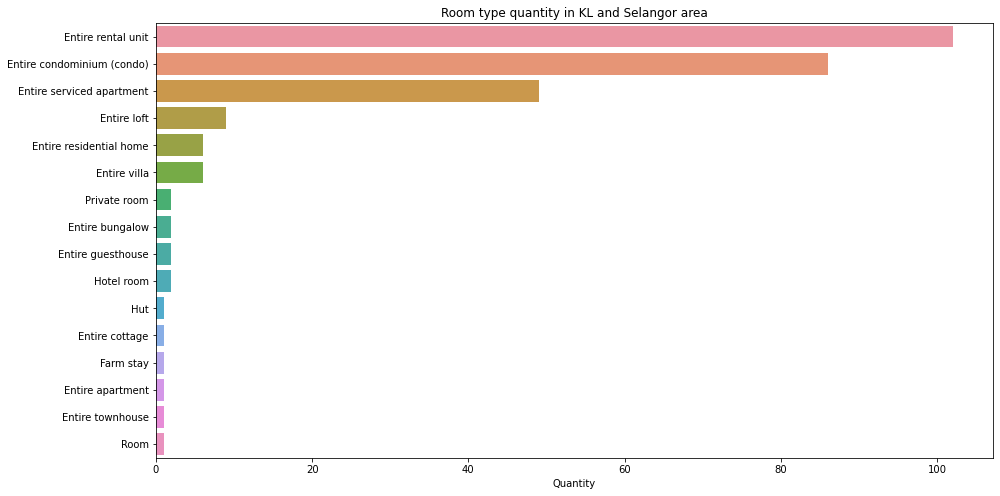

In [11]:
plt.figure(figsize=(15,8))
sns.barplot(y = df.Room.value_counts().index, x=df.Room.value_counts().values)
plt.title('Room type quantity in KL and Selangor area')
plt.xlabel('Quantity')

- common room types in KL and Selangor area (Entire rental unit, Entire condo and Entire serviced apartment)

### New features - Number of Guests

Text(0, 0.5, 'Count (room type)')

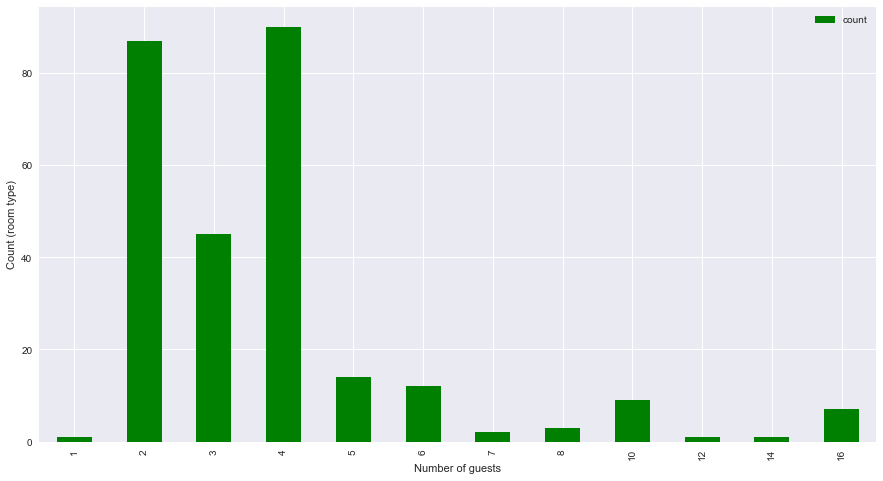

In [98]:
for idx, guests in enumerate(df.Descriptions):
    for guest in guests.split(','):
        if 'guest' in guest:
            guest = guest.split(' ')
            df.loc[idx, 'Number_of_guest'] = guest[0]
            break
df.Number_of_guest = df.Number_of_guest.astype('int64')
guest = pd.DataFrame(df.Number_of_guest.value_counts()).reset_index()
guest = guest.rename(columns = {'index':'Number of guests', 'Number_of_guest':'count'}).sort_values(by='Number of guests').set_index('Number of guests')

guest.plot(kind='bar', color='green', figsize=(15,8))
plt.ylabel('Count (room type)')

### New features - Bed type

In [13]:
df['bed_type'] = [type.split(',')[1] for type in df.Descriptions]
df.bed_type.value_counts()

 1 bedroom     125
 Studio        115
 2 bedrooms     10
 3 bedrooms     10
 4 bedrooms      7
 5 bedrooms      2
 6 bedrooms      2
 8 bedrooms      1
Name: bed_type, dtype: int64

### New features - Number of bed

In [14]:
for idx, beds in enumerate(df.Descriptions):
    for bed in beds.split(',')[2:]:
        if 'bed' in bed:
            bed = bed.split(' ')
            df.loc[idx, 'Number_of_bed'] = bed[1]
            break
            
df.Number_of_bed = df.Number_of_bed.astype('float64')
df.Number_of_bed.value_counts()

1.0     177
2.0      48
3.0      13
4.0       9
5.0       5
12.0      4
0.0       4
10.0      2
7.0       2
6.0       2
8.0       2
20.0      1
18.0      1
Name: Number_of_bed, dtype: int64

### New features - Number of bath

In [15]:
for idx, baths in enumerate(df.Descriptions):
    for bath in baths.split(',')[2:]:
        if 'bath' in bath:
            bath = bath.split(' ')
            df.loc[idx, 'Number_of_bath'] = bath[1]
            break
df.Number_of_bath.value_counts()

1            200
1.5           31
2             20
3              8
5              2
Half-bath      2
4.5            2
2.5            2
4              2
6              1
7              1
8              1
Name: Number_of_bath, dtype: int64

### New features - Wifi, Air Cond, Kitchen, Self Check-in

In [16]:
df['wifi'] = [True if 'Wifi' in wifi else False for wifi in df.Descriptions]
df['Air_cond'] = [True if 'Air conditioning' in ac else False for ac in df.Descriptions]
df['Kitchen'] = [True if 'Kitchen' in Kitchen else False for Kitchen in df.Descriptions]
df['Self_check_in'] = [True if 'Self check-in' in sci else False for sci in df.Descriptions]

### New features - Price in MYR

In [17]:
us_to_myr = 4.5

df['Price_in_MYR'] = df.Price.apply(lambda x: int(x.split(' ')[0].replace('$', '')) * us_to_myr)
# to double confirm if every listing is per night
unit_price = df.Price.apply(lambda x: ' '.join(x.split(' ')[1:]))
unit_price.value_counts()

per night    272
Name: Price, dtype: int64

### New features - Price in MYR per guest

In [18]:
df['Price_in_MYR_per_guest'] = df['Price_in_MYR'] / df['Number_of_guest']
df[['Price_in_MYR', 'Number_of_guest', 'Price_in_MYR_per_guest']].head()

,Price_in_MYR,Number_of_guest,Price_in_MYR_per_guest
0,85.5,4,21.375
1,117.0,2,58.500
2,157.5,2,78.750
3,49.5,6,8.250
4,58.5,2,29.250


### New dataset after cleaning

In [19]:
useful_features = ['Location', 'Room', 'Number_of_guest', 'bed_type', 'Number_of_bed', 'Number_of_bath', 'wifi', 'Air_cond', 'Kitchen', 'Self_check_in', 'Rating', 'Price_in_MYR', 'Price_in_MYR_per_guest']
data = df[useful_features]
data.to_csv('/Users/Asus/Desktop/Unity Game/python/Data_Analysis/WebScrapping/Abnb/dataset_afterClean.csv', index=False)
data.head()

,Location,Room,Number_of_guest,bed_type,Number_of_bed,Number_of_bath,wifi,Air_cond,Kitchen,Self_check_in,Rating,Price_in_MYR,Price_in_MYR_per_guest
0,Kuala Lumpur,Entire serviced apartment,4,Studio,1.0,1,True,True,True,True,4.86,85.5,21.375
1,Kuala Lumpur,Entire serviced apartment,2,Studio,1.0,1,True,True,True,False,4.77,117.0,58.500
2,Kuala Lumpur,Entire rental unit,2,1 bedroom,1.0,1,True,True,True,True,4.95,157.5,78.750
3,Kuala Lumpur,Entire serviced apartment,6,3 bedrooms,3.0,2,True,True,True,False,NaN,49.5,8.250
4,Kuala Lumpur,Hotel room,2,1 bedroom,1.0,1,True,True,False,True,4.51,58.5,29.250


# Data Analysis

<a id="1"></a>
### 1. What Room type has highest price in MYR ?

[back to top](#0)

#### Overall
- Regardless of number of guest in one room

In [20]:
highest_room_price = data.groupby('Room').agg({'Price_in_MYR': ['median', 'mean', 'max', 'min','count']})
highest_room_price_sort = highest_room_price.Price_in_MYR.sort_values(by='median', ascending=False)
print('Top 5 expansive room (median, mean, max, min and count)')
highest_room_price_sort.head()

Top 5 expansive room (median, mean, max, min and count)


,median,mean,max,min,count
Room,,,,,
Farm stay,1849.5,1849.5,1849.5,1849.5,1
Entire villa,1201.5,1405.5,2826.0,787.5,6
Hut,1143.0,1143.0,1143.0,1143.0,1
Entire cottage,886.5,886.5,886.5,886.5,1
Entire townhouse,805.5,805.5,805.5,805.5,1


Room type follow by price


Text(0.5, 0, 'median price in MYR')

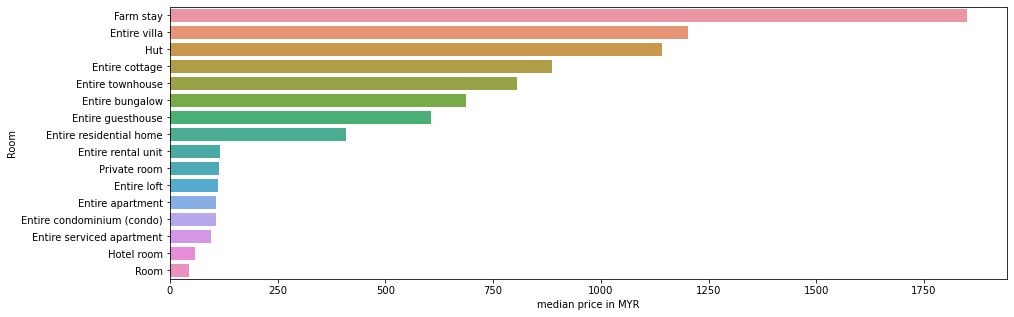

In [21]:
print('Room type follow by price')
room = highest_room_price_sort.index
plt.figure(figsize=(15, 5))
sns.barplot(data=highest_room_price_sort, y=room, x='median')
plt.xlabel('median price in MYR')

Room price pie chart


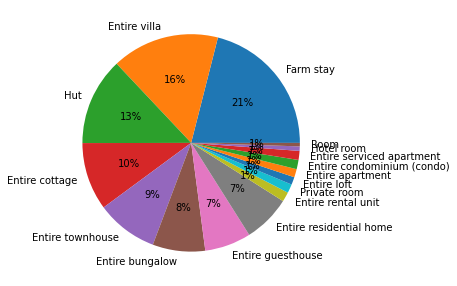

In [22]:
print('Room price pie chart')
plt.figure(figsize=(5, 5))
plt.pie(data=highest_room_price_sort, x='mean', labels=room, autopct='%.0f%%')
plt.show()

In [23]:
print('Room versue number of guests')
data.groupby('Room').agg('median')[['Number_of_guest', 'Price_in_MYR']].sort_values(by='Number_of_guest', ascending=False)

Room versue number of guests


,Number_of_guest,Price_in_MYR
Room,,
Hut,16.0,1143.00
Entire bungalow,15.0,686.25
Entire cottage,12.0,886.50
Entire residential home,10.0,409.50
Entire townhouse,10.0,805.50
Entire villa,10.0,1201.50
Entire guesthouse,9.5,605.25
Farm stay,8.0,1849.50
Entire loft,4.0,112.50


- No suprise to see, the room with more number of guest are more expansive than those room with fewer guests

#### per guest
- Next step, we want to see if we calculate room price per guest instead of overall, will the result be different?

In [24]:
highest_room_price_per_guest = data.groupby('Room').agg(['median', 'mean', 'max', 'min', 'count'])[['Price_in_MYR_per_guest']]
highest_room_price_per_guest_sorted = highest_room_price_per_guest.Price_in_MYR_per_guest.sort_values(by='median', ascending=False)
print('Top 5 expansive room (median, mean, max, min and count) per guest')
highest_room_price_per_guest_sorted.head()

Top 5 expansive room (median, mean, max, min and count) per guest


,median,mean,max,min,count
Room,,,,,
Farm stay,231.187500,231.187500,231.1875,231.18750,1
Entire villa,136.339286,131.537054,176.6250,71.71875,6
Entire townhouse,80.550000,80.550000,80.5500,80.55000,1
Entire cottage,73.875000,73.875000,73.8750,73.87500,1
Hut,71.437500,71.437500,71.4375,71.43750,1


Room price comparison with overall and per guest


Text(0.5, 1.0, 'median price in MYR (per guest)')

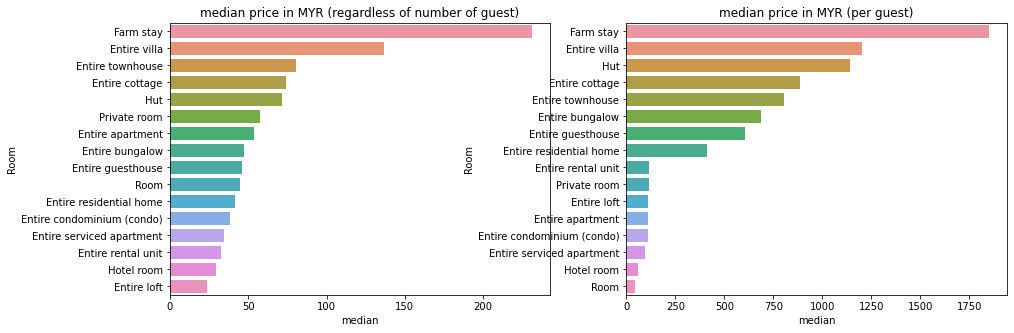

In [25]:
room_per_guest = highest_room_price_per_guest_sorted.index
print('Room price comparison with overall and per guest')
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# plt.figure(figsize=(15, 5))
sns.barplot(data=highest_room_price_per_guest_sorted, y=room_per_guest, x='median', ax=ax[0])
sns.barplot(data=highest_room_price_sort, y=room, x='median', ax=ax[1])
ax[0].set_title('median price in MYR (regardless of number of guest)')
ax[1].set_title('median price in MYR (per guest)')

- From the comparison of overall's and per guest's room price, we can tell that room types Farm stay, Entire villa, Entire townhouse, Entire cottage and Hut are still the highest compare to others.

<a id="2"></a>
### 2. Did wifi, air-cond, kitchen or self-check in bring impact the price ?

[back to top](#0)

### I) Wifi<a id="3"></a>

In [26]:
print('Wifi availability comparison in mean, median, max, min and count')
data.groupby('wifi').agg(['mean', 'median', 'max', 'min', 'count'])[['Price_in_MYR']]

Wifi availability comparison in mean, median, max, min and count


Price_in_MYR                           
              mean median     max   min count
wifi                                         
False   695.250000  661.5  1849.5  54.0    12
True    159.421154  112.5  2826.0  45.0   260

- Only 12 rooms do not provide wifi 

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'No wifi')

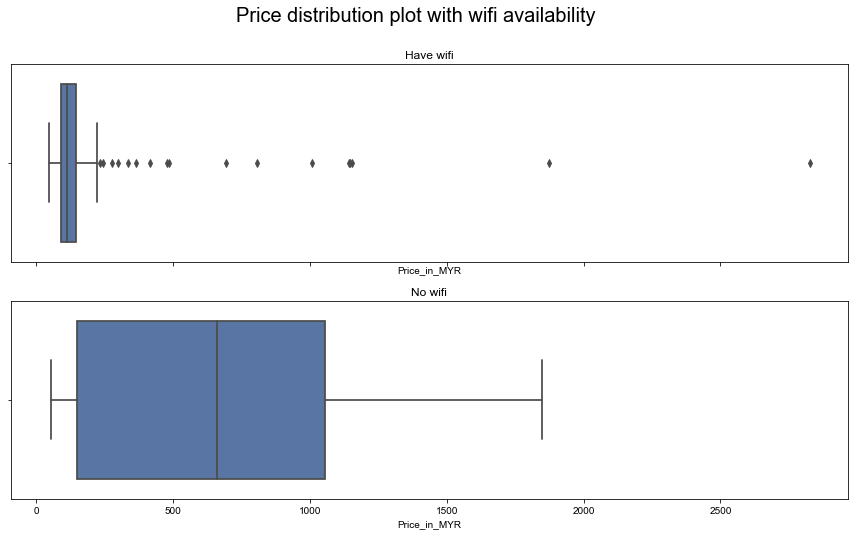

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
fig.suptitle('Price distribution plot with wifi availability', fontsize=20)
plt.style.use('seaborn')

sns.boxplot(data[df.wifi==True].Price_in_MYR, ax=ax[0])
sns.boxplot(data[df.wifi==False].Price_in_MYR, ax=ax[1])
ax[0].set_title('Have wifi')
ax[1].set_title('No wifi')

In [28]:
print('Table for room which do not have wifi and their room price')
data[data.wifi == False][['Room', 'wifi', 'Price_in_MYR']].sort_values(by='Price_in_MYR', ascending=False)

Table for room which do not have wifi and their room price


,Room,wifi,Price_in_MYR
214,Farm stay,False,1849.5
240,Entire villa,False,1426.5
139,Entire villa,False,1255.5
189,Entire villa,False,990.0
270,Entire cottage,False,886.5
151,Entire villa,False,787.5
208,Entire residential home,False,535.5
218,Entire residential home,False,216.0
269,Entire serviced apartment,False,171.0
5,Entire serviced apartment,False,85.5


- Around 95% of room provid wifi. The room which did not provide wifi can be expansive room (Farm stay or entire villa), or budget room (entire loft or entire serviced apartment). No significant correlation found between wifi and room price.

### II) air-cond  <a id="4"></a>

In [29]:
print('Question: How many room provide Air-cond?')
print(f'Answer: {data.Air_cond.sum() / len(data) *100:.2f}% of room provide Air-cond')

Question: How many room provide Air-cond?
Answer: 98.90% of room provide Air-cond


In [30]:
print('Room which do not have air-cond and the room price')
data[data.Air_cond == False][['Location', 'Room', 'Air_cond', 'Price_in_MYR']]

Room which do not have air-cond and the room price


,Location,Room,Air_cond,Price_in_MYR
214,Hulu Langat,Farm stay,False,1849.5
237,Selangor,Entire guesthouse,False,58.5
270,Lenggeng,Entire cottage,False,886.5


- Most of the room provided air-conditioning facilities (up to 99%). We cannot tell if room price rise due to air-cond provided.

### III) Kitchen <a id="5"></a>

In [31]:
print('Kitchen availability comparison in mean, median, max, min and count')
data.groupby('Kitchen').agg(['mean', 'median', 'max', 'min', 'count'])[['Price_in_MYR']]

Kitchen availability comparison in mean, median, max, min and count


Price_in_MYR                           
                mean median     max   min count
Kitchen                                        
False      87.333333   85.5   171.0  45.0    27
True      193.610204  117.0  2826.0  45.0   245

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'No kitchen provided')

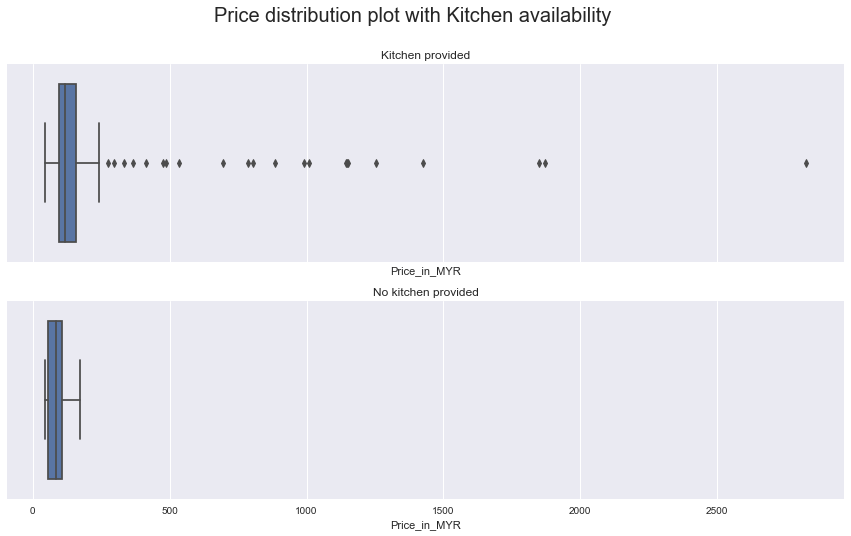

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
fig.suptitle('Price distribution plot with Kitchen availability', fontsize=20)
plt.style.use('seaborn')

sns.boxplot(data[df.Kitchen==True].Price_in_MYR, ax=ax[0])
sns.boxplot(data[df.Kitchen==False].Price_in_MYR, ax=ax[1])
ax[0].set_title('Kitchen provided')
ax[1].set_title('No kitchen provided')

- Majority of room provide kitchen (up to 90%). From distribution plot above, the mean price for room has kitchen is slightly higher than room without kitchen

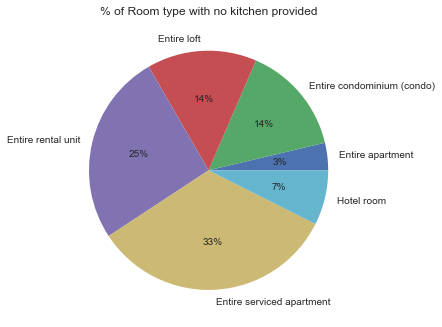

In [33]:
room_with_no_kitchen = data[data.Kitchen==False].groupby('Room').Location.count()

plt.pie(data=room_with_no_kitchen, labels=room_with_no_kitchen.index, x=room_with_no_kitchen.values, autopct='%d%%')
plt.title('% of Room type with no kitchen provided')
plt.show()

- Above show the pie chart for room without kitchen provided. All of this room are budget room type which less than RM120 (median) per night. Room with kitchen genarally has higher price than room without kitchen.

### self-check in <a id="6"></a>

In [34]:
print('Self-Check in availability comparison in mean, median, max, min and count')
data.groupby('Self_check_in').agg(['mean', 'median', 'max', 'min', 'count'])[['Price_in_MYR']]

Self-Check in availability comparison in mean, median, max, min and count


Price_in_MYR                           
                      mean median     max   min count
Self_check_in                                        
False           232.796178  117.0  2826.0  45.0   157
True            115.160870  108.0   220.5  45.0   115

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'No Self_check_in provided')

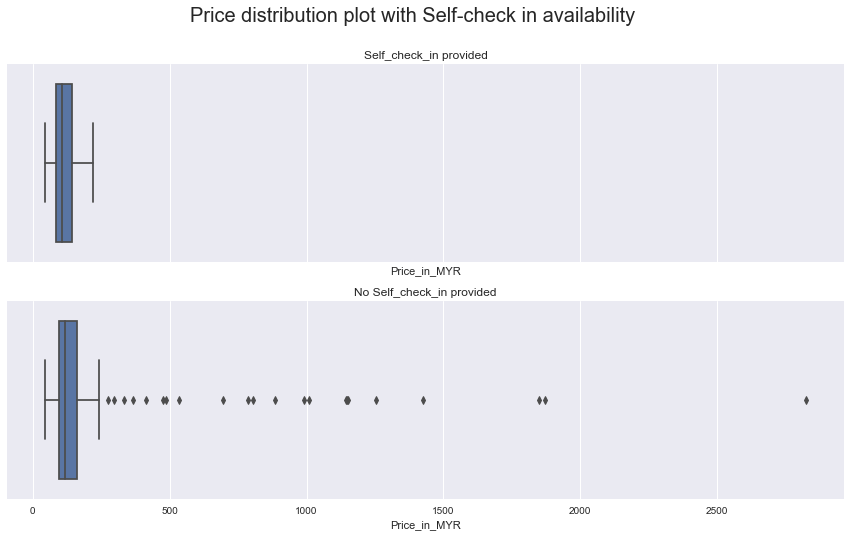

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
fig.suptitle('Price distribution plot with Self-check in availability', fontsize=20)
plt.style.use('seaborn')

sns.boxplot(data[df.Self_check_in==True].Price_in_MYR, ax=ax[0])
sns.boxplot(data[df.Self_check_in==False].Price_in_MYR, ax=ax[1])
ax[0].set_title('Self_check_in provided')
ax[1].set_title('No Self_check_in provided')

In [36]:
data[data.Self_check_in == False][['Room', 'Price_in_MYR']].sort_values(by='Price_in_MYR', ascending=False).iloc[:10]

,Room,Price_in_MYR
168,Entire villa,2826.0
261,Entire residential home,1872.0
214,Farm stay,1849.5
240,Entire villa,1426.5
139,Entire villa,1255.5
254,Entire guesthouse,1152.0
212,Entire villa,1147.5
267,Hut,1143.0
209,Entire bungalow,1008.0
189,Entire villa,990.0


 -  Generally expansive room does not provide self check in. As looking from distribution plot above, the mean value for both are quite similar.

### Correlation graph

Text(0.5, 1.0, 'Correlation graph')

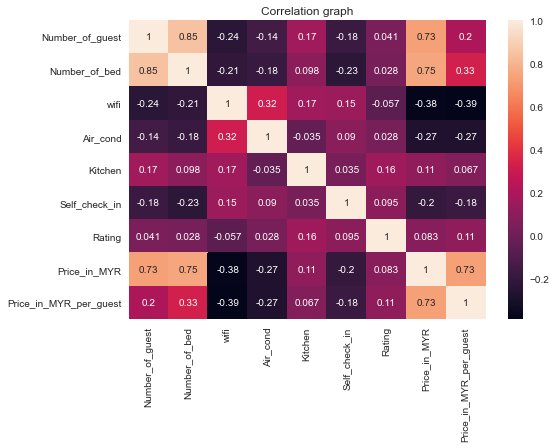

In [37]:
sns.heatmap(data.corr(), annot=True)
plt.title('Correlation graph')

- Similary, the correlation graph shown that wifi, air-cond and self-check in does not bring significant impact to room price. While room price tend to be on high side if the room provide kitchen facility.

<a id="8"></a>
### 3. Bed type, Number of bed and price relationship
[back to top](#0)

In [38]:
print('Relatioship of Bed type and number of bed')
data.groupby('bed_type').agg(['median', 'max', 'min', 'count'])['Number_of_bed'].sort_values(by='median', ascending=False)

Relatioship of Bed type and number of bed


,median,max,min,count
bed_type,,,,
6 bedrooms,15.0,18.0,12.0,2
8 bedrooms,12.0,12.0,12.0,1
5 bedrooms,10.0,12.0,8.0,2
4 bedrooms,7.0,20.0,0.0,7
3 bedrooms,4.5,8.0,3.0,10
2 bedrooms,3.0,12.0,2.0,10
1 bedroom,1.0,4.0,0.0,123
Studio,1.0,4.0,0.0,115


Relatioship of Bed type and number of bed (graph)


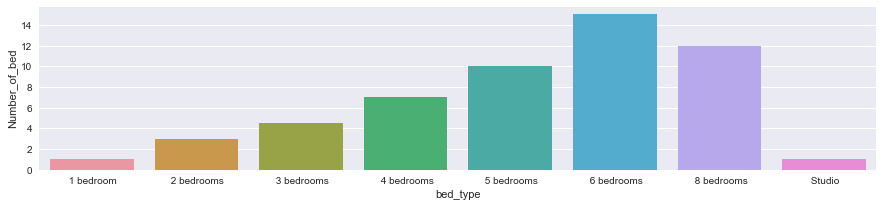

In [39]:
bed_count = data.groupby('bed_type').agg('median')[['Number_of_bed']].reset_index()
plt.figure(figsize=(15,3))
sns.barplot(x=bed_count.bed_type, y=bed_count.Number_of_bed)
print('Relatioship of Bed type and number of bed (graph)')

- The higher bedroom type value, the higher the number of bed

In [40]:
 print('Relatioship of Bed type and price in MYR')
data.groupby('bed_type').agg(['median', 'mean', 'max', 'min', 'count'])['Price_in_MYR'].sort_values(by='median', ascending=False)

Relatioship of Bed type and price in MYR


,median,mean,max,min,count
bed_type,,,,,
8 bedrooms,2826.00,2826.000000,2826.0,2826.0,1
6 bedrooms,1102.50,1102.500000,1872.0,333.0,2
5 bedrooms,1077.75,1077.750000,1147.5,1008.0,2
4 bedrooms,535.50,678.857143,1152.0,216.0,7
3 bedrooms,243.00,373.050000,1255.5,49.5,10
2 bedrooms,227.25,521.100000,1426.5,139.5,10
1 bedroom,112.50,116.820000,297.0,45.0,125
Studio,103.50,124.434783,1849.5,54.0,115


Relatioship of Bed type and price in MYR (graph)


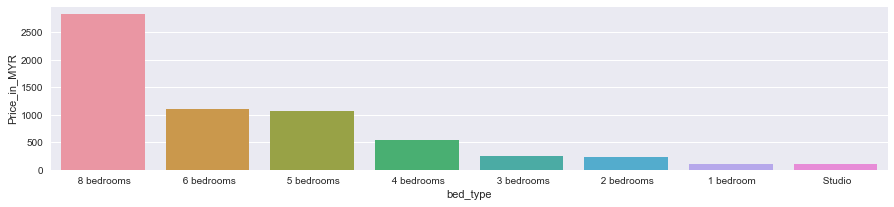

In [41]:
bed_price = data.groupby('bed_type').agg('median')[['Price_in_MYR']].sort_values(by='Price_in_MYR', ascending=False).reset_index()
plt.figure(figsize=(15, 3))
sns.barplot(x=bed_price.bed_type, y=bed_price.Price_in_MYR)
print('Relatioship of Bed type and price in MYR (graph)')

- Is a directly propotional relatiship between bedroom type (number of bed) and room price.

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Asus\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 47.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Swarm plot for bed type and price


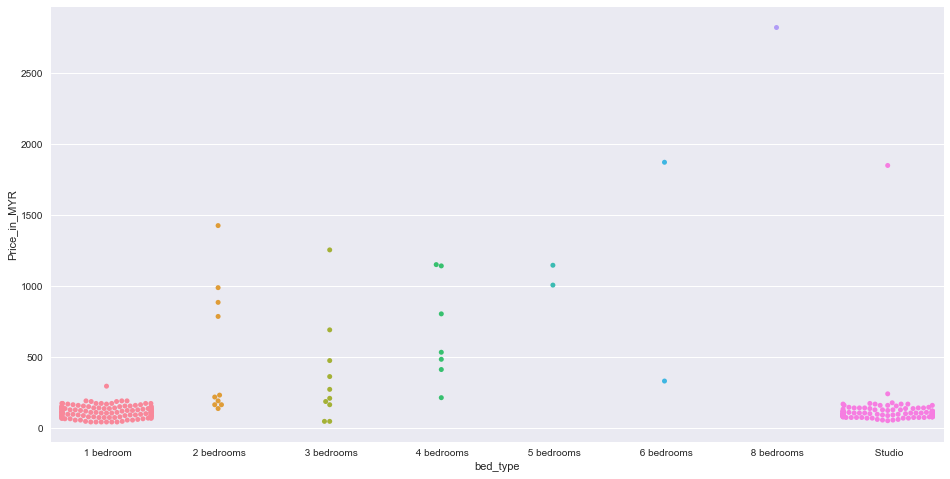

In [42]:
plt.figure(figsize=(16, 8))
sns.swarmplot(x=data.bed_type.sort_values(), y=data.Price_in_MYR)
print('Swarm plot for bed type and price')

- Strong correlation between bed type (number of bed) and room price.
- The room price for 1 bedroom type and studio are more consistent than others.

<a id="9"></a>
### 4. Did number of bath bring impact to the price ?
[back to top](#0)

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Swarm plot for Number of bath and price


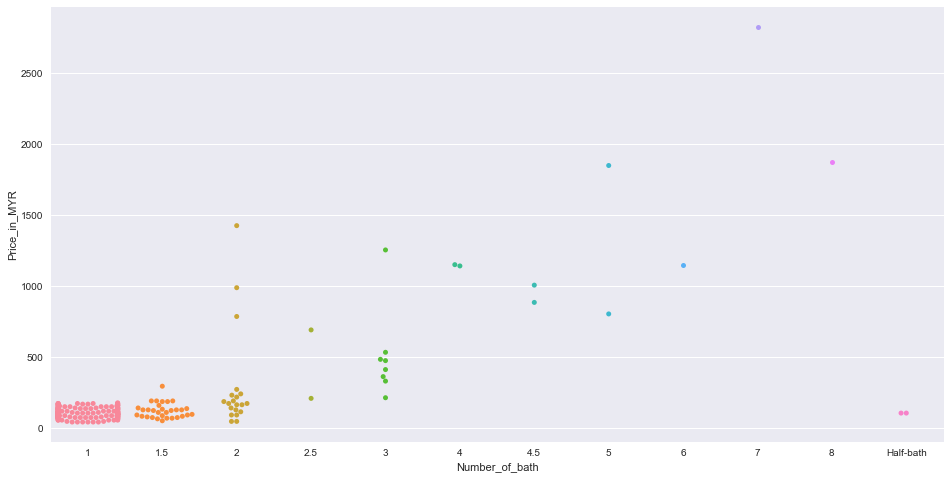

In [43]:
plt.figure(figsize=(16, 8))
sns.swarmplot(x=data.Number_of_bath.sort_values(), y=data.Price_in_MYR)
print('Swarm plot for Number of bath and price')

Relatioship of Number_of_bath and price in MYR (graph)


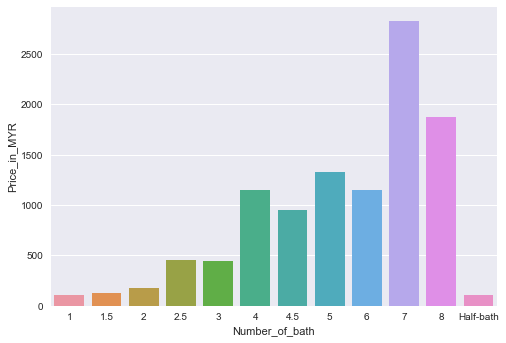

In [44]:
bath = data.groupby('Number_of_bath').agg('median')['Price_in_MYR'].reset_index()
sns.barplot(data=bath, x='Number_of_bath', y='Price_in_MYR')
print('Relatioship of Number_of_bath and price in MYR (graph)')

- Strong correlation between number of bath and room price.

<a id="10"></a>
### 5. Location and Room price
[back to top](#0)

- We look at Entire condominium (condo) price vary across KL and Selangor area. But before that, we need to do some cleaning in Location

In [45]:
print('Location list')
data.Location.unique()

Location list


array(['Kuala Lumpur', 'Bukit Bintang',
       'Federal Territory of Kuala Lumpur', 'Kampung Baru',
       'Seri Kembangan', 'Cheras', 'Kuala Kubu Baru', 'Petaling Jaya',
       'Batu 9 Cheras', 'Sri Hartamas', 'i-City', 'Hulu Langat',
       'Balakong', 'Cyberjaya', 'Kuala Selangor', 'Shah Alam', 'Ampang',
       'Sungai Buloh', 'Sepang', 'KUALA LUMPUR', 'Selangor',
       'Damansara Perdana', 'Rawang', 'Tanjong Sepat', 'Serendah',
       'Batang Kali', 'Lenggeng'], dtype=object)

In [46]:
# group all KL area
data['new_location'] = data.Location.apply(lambda x: 'Kuala Lumpur' if 'kuala lumpur' in str(x).lower() else str(x))

<ipython-input-46-148c66ab679f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_location'] = data.Location.apply(lambda x: 'Kuala Lumpur' if 'kuala lumpur' in str(x).lower() else str(x))


In [47]:
print('After grouping all KL area')
data.new_location.unique()

After grouping all KL area


array(['Kuala Lumpur', 'Bukit Bintang', 'Kampung Baru', 'Seri Kembangan',
       'Cheras', 'Kuala Kubu Baru', 'Petaling Jaya', 'Batu 9 Cheras',
       'Sri Hartamas', 'i-City', 'Hulu Langat', 'Balakong', 'Cyberjaya',
       'Kuala Selangor', 'Shah Alam', 'Ampang', 'Sungai Buloh', 'Sepang',
       'Selangor', 'Damansara Perdana', 'Rawang', 'Tanjong Sepat',
       'Serendah', 'Batang Kali', 'Lenggeng'], dtype=object)

<AxesSubplot:ylabel='new_location'>

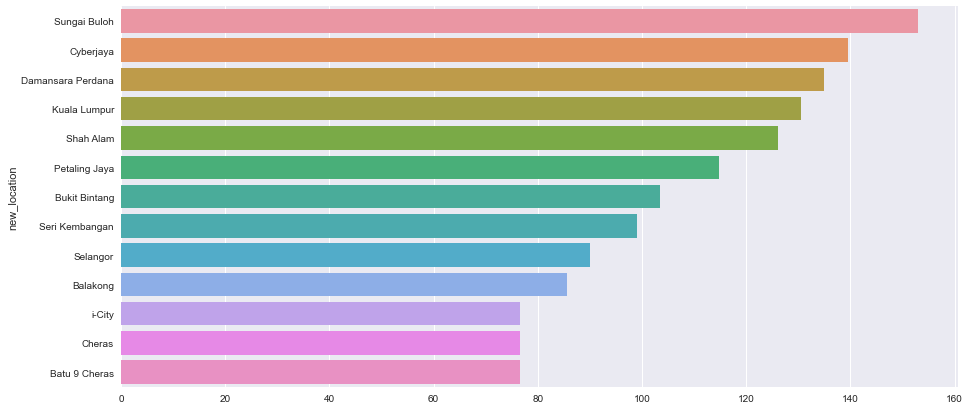

In [48]:
condo_price = data.groupby(['Room', 'new_location']).agg('median')['Price_in_MYR'].loc['Entire condominium (condo)'].sort_values(ascending=False)
plt.figure(figsize=(15,7))
sns.barplot(y=condo_price.index, x=condo_price.values)
# sns.swarmplot(y=data.new_location.sort_values(), x=data.Price_in_MYR)

<a id="7"></a>
### 6. Correlation between rating and price
[back to top](#0)

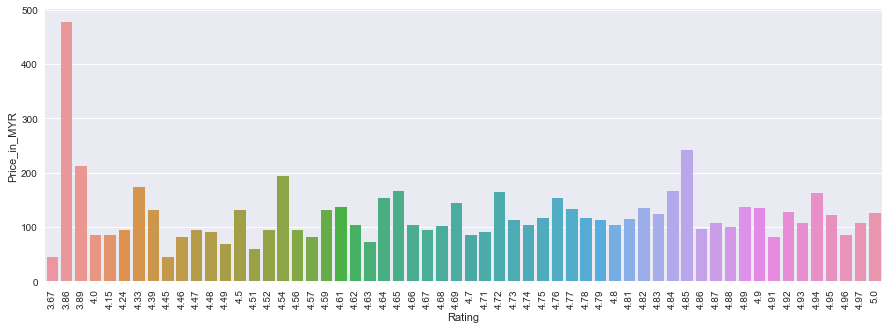

In [49]:
rating_price = data.groupby('Rating').agg('median')[['Price_in_MYR']]
plt.figure(figsize=(15,5))
sns.barplot(x=rating_price.index, y=rating_price.Price_in_MYR)
plt.xticks(rotation='vertical')
plt.show()

- Rating vs price in expansive room type (price higher than RM600 per night (mean price))

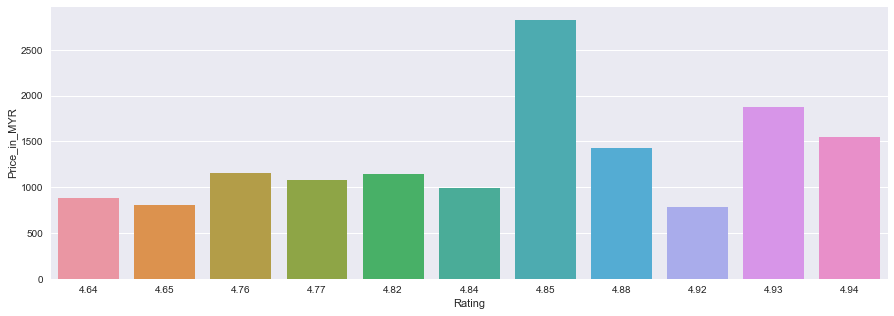

In [50]:
expensive_room_rating = data[data.Price_in_MYR > 600].groupby('Rating').agg('mean')[['Price_in_MYR']]
plt.figure(figsize=(15,5))
sns.barplot(x=expensive_room_rating.index, y=expensive_room_rating.Price_in_MYR)
plt.show()

- to be continue

<a id="100"></a>
### Conclusion
[back to top](#0)

- Farm stay is the most expansive room type (regardless number of guest or per guest). The top 5 most expansive room types are Farm stay, Entire villa, Entire townhouse, Entire cottage and Hut.

- Wifi, air-cond and self-check in does not bring significant impact to room price. While room price tend to be on high side if the room provide kitchen facility.

- Generally expansive room does not provide self check in

- Strong correlation between bed type (number of bed) and room price. The higher number of bed, the higher the room price.

- The room price for 1 bedroom type and studio are more consistent than others.

- Strong correlation between number of bath and room price. The higher number of bath, the higher the room price.